# Overall Algorithm

Refer to Overleaf notes with regards to the overall algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
import healsparse as hsp
import skyproj
from os import listdir
import Config
from CropSurveyProperties import *
from GetObjects import *
from TrainAndFullMap import *

In [2]:
minGR = -0.3 # Minimum G-R color
maxGR = 1 # Maximum G-R color
res = 512 # Healpixel resolution
perCovered = 0.6 # Percent of healpixel that must have valid survey properties at the 4096 scale
sigma = 0.5 # Sigma used for gaussian weighting
perVar = 0.98 # Percent of the variance to be captured
perMap = 0.625 # Percent of the PC maps to use, adjust this later
numBins = 100 # Number of points in interpolation
magBins = [20, 22, 23, 24, 25, 26] # G magnitude bins
Potential_Class_Cutoffs = [0.5, 1.5, 2.5] # These are the three class cutoffs that make any sense.
Class_Cutoff = Potential_Class_Cutoffs[1] # Less than this class is a star, greater is a galaxy.

## Conditions and Overall Directory

In [3]:
conditions = Config.conditions
likeDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/'
oldGalaDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/GalaxyContamination/'

## Deep Data

In [4]:
deepFiles = ['/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000001.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000002.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000003.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000004.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000005.fits']

## Balrog Files and Location for Galaxy Information

In [5]:
detBalrFile = '/hdfs/bechtol/balrog/y3/balrog_detection_catalog_sof_y3-merged_v1.2.fits'
matBalrFile = '/hdfs/bechtol/balrog/y3/balrog_matched_catalog_sof_y3-merged_v1.2.fits'
galaFile = likeDir + 'InjectionData/Galaxies.fits'

## Location of Balrog Star Files and Star Storage

Detection catalog will be used for detection rates, but since the matched catalog can include measured magnitudes, it will be used for misclassification rates.

In [6]:
detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
detStarFile = likeDir + 'InjectionData/Det_Stars.fits'

matBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_matched_catalog_sof_run2_stars_v1.4.fits'
matStarFile = likeDir + 'InjectionData/Mat_Stars.fits'

## Location of Pixel and Condition Files

In [7]:
origCondFiles = Config.files[:-1]
stelFile = Config.files[-1]
pixFile = likeDir + 'PixAndConds/Valid_'+str(res)+'_Pixels.fits'
validPix = fitsio.read(pixFile)['PIXEL']
condFiles = []
for cond in conditions:
    condFiles.append(likeDir + 'PixAndConds/' + str(res) + '_' + cond + '.fits')
condFiles = np.array(condFiles)

## Galaxy Probabilities

In [8]:
galaDir = likeDir + 'Galaxies/'

galaExtrFiles = [galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_<20.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_20-22.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_22-23.fits',
                 galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_23-24.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_24-25.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_25-26.fits',
                 galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Extr_>26.fits']
galaTrainFiles = [galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_<20.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_20-22.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_22-23.fits',
                  galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_23-24.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_24-25.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_25-26.fits',
                  galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Train_>26.fits']
galaProbFiles = [galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_<20.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_20-22.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_22-23.fits',
                 galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_23-24.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_24-25.fits', galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_25-26.fits',
                 galaDir + 'Class_' +str(Class_Cutoff)+'_Gala_Prob_>26.fits']

## Star Classification Probabilities

In [9]:
starDir = likeDir + 'Stars/'

starExtrFiles = [starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_<20.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_20-22.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_22-23.fits',
                 starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_23-24.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_24-25.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_25-26.fits',
                 starDir + 'Class_' +str(Class_Cutoff)+'_Star_Extr_>26.fits']
starTrainFiles = [starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_<20.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_20-22.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_22-23.fits',
                  starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_23-24.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_24-25.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_25-26.fits',
                  starDir + 'Class_' +str(Class_Cutoff)+'_Star_Train_>26.fits']
starProbFiles = [starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_<20.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_20-22.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_22-23.fits',
                 starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_23-24.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_24-25.fits', starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_25-26.fits',
                 starDir + 'Class_' +str(Class_Cutoff)+'_Star_Prob_>26.fits']

## Star Detection Probabilities

In [10]:
starDetExtrFiles = [starDir + 'Star_Det_Extr_<20.fits', starDir + 'Star_Det_Extr_20-22.fits', starDir + 'Star_Det_Extr_22-23.fits',
                 starDir + 'Star_Det_Extr_23-24.fits', starDir + 'Star_Det_Extr_24-25.fits', starDir + 'Star_Det_Extr_25-26.fits',
                 starDir + 'Star_Det_Extr_>26.fits']
starDetTrainFiles = [starDir + 'Star_Det_Train_<20.fits', starDir + 'Star_Det_Train_20-22.fits', starDir + 'Star_Det_Train_22-23.fits',
                  starDir + 'Star_Det_Train_23-24.fits', starDir + 'Star_Det_Train_24-25.fits', starDir + 'Star_Det_Train_25-26.fits',
                  starDir + 'Star_Det_Train_>26.fits']
starDetProbFiles = [starDir + 'Star_Det_Prob_<20.fits', starDir + 'Star_Det_Prob_20-22.fits', starDir + 'Star_Det_Prob_22-23.fits',
                 starDir + 'Star_Det_Prob_23-24.fits', starDir + 'Star_Det_Prob_24-25.fits', starDir + 'Star_Det_Prob_25-26.fits',
                 starDir + 'Star_Det_Prob_>26.fits']

## Getting Synthetic Objects

In [11]:
# getMatStars(minGR, maxGR, matBalrStarFile, detBalrStarFile, matStarFile)

In [12]:
# getDetStar(minGR, maxGR, detBalrStarFile, detStarFile)

In [13]:
# getGalaxies(minGR, maxGR, deepFiles, matBalrFile, detBalrFile, galaFile)

## Crop Conditions to Valid Pixels

In [14]:
# validPixCropData(res, origCondFiles, stelFile, pixFile, condFiles, perCovered)

## Training

In [15]:
# singleCorrectionTrain(matStarFile, condFiles, pixFile, magBins, starTrainFiles, starProbFiles, starExtrFiles, sigma, perMap, perVar, numBins, res, True, False, Class_Cutoff)
for starTrainFile in starTrainFiles:
    print(loadtxt(starTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9953365169377705
0.9813493286548598
0.9401516528881426
0.8161554095571206
0.5225229357798166
0.43173661099191946
0.4166437414030261


In [16]:
# singleCorrectionTrain(detStarFile, condFiles, pixFile, magBins, starDetTrainFiles, starDetProbFiles, starDetExtrFiles, sigma, perMap, perVar, numBins, res, True, True, Class_Cutoff)
for starDetTrainFile in starDetTrainFiles:
    print(loadtxt(starDetTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9945726246105919
0.9899198201350476
0.9804114719614181
0.966991406100484
0.7513843427755765
0.1053889075042613
0.0027800480073104966


In [17]:
# singleCorrectionTrain(galaFile, condFiles, pixFile, magBins, galaTrainFiles, galaProbFiles, galaExtrFiles, sigma, perMap, perVar, numBins, res, False, False, Class_Cutoff)
for galaTrainFile in galaTrainFiles:
    print(loadtxt(galaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9351532210951192
0.9553489449017557
0.9758779983761174
0.9635135987555853
0.9050432090661259
0.8364036028307956
0.8138543107422775


In [18]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel2/'
files = listdir(dirStars)
usedCols = ['FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R', 'SOF_CM_MAG_G', 'SOF_CM_MAG_R', 'RA', 'DEC']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True
newMagBins = magBins[:-1]

In [19]:
# ZEROPIX = []
# ONESTARPIX = []
# ONEGALAPIX = []
# TWOSTARPIX = []
# TWOGALAPIX = []
# THREEPIX = []

# for i in range(len(newMagBins)):
    
#     magZeroPix = []
#     magOneStarPix = []
#     magOneGalaPix = []
#     magTwoStarPix = []
#     magTwoGalaPix = []
#     magThreePix = []
    
#     for file in files:
#         obsData = fitsio.read(dirStars + file, columns = usedCols)
#         FOREGROUND = obsData[usedCols[0]]
#         BADREGIONS = obsData[usedCols[1]]
#         FOOTPRINT = obsData[usedCols[2]]
#         CLASS = obsData[usedCols[3]]
#         GMAG = obsData[usedCols[4]]
#         RMAG = obsData[usedCols[5]]
#         GMAG_GALA = obsData[usedCols[6]]
#         RMAG_GALA = obsData[usedCols[7]]
#         RA = obsData[usedCols[8]]
#         DEC = obsData[usedCols[9]]
#         PIX = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)
        
#         # General Quality Cuts
#         qualityCut = np.where((FOREGROUND == 0) &
#                               (BADREGIONS < 2) &
#                               (FOOTPRINT == 1) &
#                               (pixCheck[PIX]))[0]
        
#         CLASS = CLASS[qualityCut]
#         GMAG = GMAG[qualityCut]
#         RMAG = RMAG[qualityCut]
#         GMAG_GALA = GMAG_GALA[qualityCut]
#         RMAG_GALA = RMAG_GALA[qualityCut]
#         PIX = PIX[qualityCut]
        
#         if i == 0:
#             magCut = np.where(GMAG <= newMagBins[i])[0]
#         else:
#             magCut = np.where((GMAG <= newMagBins[i]) & (GMAG > newMagBins[i - 1]))[0]
        
#         boolMagCut = np.zeros(len(GMAG))
#         boolMagCut[magCut] = 1
        
#         if i == 0:
#             magCutGala = np.where(GMAG_GALA <= newMagBins[i])[0]
#         else:
#             magCutGala = np.where((GMAG_GALA <= newMagBins[i]) & (GMAG_GALA > newMagBins[i - 1]))[0]
        
#         boolMagCutGala = np.zeros(len(GMAG_GALA))
#         boolMagCutGala[magCutGala] = 1
        
#         # Class Zero Cut:
        
#         zeroCut = np.where((CLASS == 0) & 
#                            (boolMagCut > 0) &
#                            ((GMAG - RMAG) <= maxGR) &
#                            ((GMAG - RMAG) >= minGR))[0]
        
#         magZeroPix.extend(PIX[zeroCut])
        
#         # Class One Star Cut:
        
#         oneStarCut = np.where((CLASS == 1) & 
#                            (boolMagCut > 0) &
#                            ((GMAG - RMAG) <= maxGR) &
#                            ((GMAG - RMAG) >= minGR))[0]
        
#         magOneStarPix.extend(PIX[oneStarCut])
        
#         # Class One Galaxy Cut:
        
#         oneGalaCut = np.where((CLASS == 1) & 
#                            (boolMagCutGala > 0) &
#                            ((GMAG_GALA - RMAG_GALA) <= maxGR) &
#                            ((GMAG_GALA - RMAG_GALA) >= minGR))[0]
        
#         magOneGalaPix.extend(PIX[oneGalaCut])
        
#         # Class Two Star Cut:
        
#         twoStarCut = np.where((CLASS == 2) & 
#                            (boolMagCut > 0) &
#                            ((GMAG - RMAG) <= maxGR) &
#                            ((GMAG - RMAG) >= minGR))[0]
        
#         magTwoStarPix.extend(PIX[twoStarCut])
        
#         # Class Two Galaxy Cut:
        
#         twoGalaCut = np.where((CLASS == 2) & 
#                            (boolMagCutGala > 0) &
#                            ((GMAG_GALA - RMAG_GALA) <= maxGR) &
#                            ((GMAG_GALA - RMAG_GALA) >= minGR))[0]
        
#         magTwoGalaPix.extend(PIX[twoGalaCut])
        
#         # Class Three Cut:
        
#         threeCut = np.where((CLASS == 3) &
#                            (boolMagCutGala > 0) &
#                            ((GMAG_GALA - RMAG_GALA) <= maxGR) &
#                            ((GMAG_GALA - RMAG_GALA) >= minGR))[0]
        
#         magThreePix.extend(PIX[threeCut])
        
#     ZEROPIX.append(np.array(magZeroPix))
#     ONESTARPIX.append(np.array(magOneStarPix))
#     ONEGALAPIX.append(np.array(magOneGalaPix))
#     TWOSTARPIX.append(np.array(magTwoStarPix))
#     TWOGALAPIX.append(np.array(magTwoGalaPix))
#     THREEPIX.append(np.array(magThreePix))
    
# ZEROPIX = np.array(ZEROPIX, dtype = object)
# ONESTARPIX = np.array(ONESTARPIX, dtype = object)
# ONEGALAPIX = np.array(ONEGALAPIX, dtype = object)
# TWOSTARPIX = np.array(TWOSTARPIX, dtype = object)
# TWOGALAPIX = np.array(TWOGALAPIX, dtype = object)
# THREEPIX = np.array(THREEPIX, dtype = object)

# OBJPIX = [ZEROPIX, ONESTARPIX, ONEGALAPIX, TWOSTARPIX, TWOGALAPIX, THREEPIX]

In [20]:
zeroDir = likeDir + 'Class_0/'
oneStarDir = likeDir + 'Class_1_Star/'
oneGalaDir = likeDir + 'Class_1_Galaxy/'
twoStarDir = likeDir + 'Class_2_Star/'
twoGalaDir = likeDir + 'Class_2_Galaxy/'
threeDir = likeDir + 'Class_3/'

obsZeroFiles = [zeroDir + '<20.fits', zeroDir + '20-22.fits', zeroDir + '22-23.fits',
                zeroDir + '23-24.fits', zeroDir + '24-25.fits', zeroDir + '25-26.fits']
obsOneStarFiles = [oneStarDir + '<20.fits', oneStarDir + '20-22.fits', oneStarDir + '22-23.fits',
                oneStarDir + '23-24.fits', oneStarDir + '24-25.fits', oneStarDir + '25-26.fits']
obsOneGalaFiles = [oneGalaDir + '<20.fits', oneGalaDir + '20-22.fits', oneGalaDir + '22-23.fits',
                oneGalaDir + '23-24.fits', oneGalaDir + '24-25.fits', oneGalaDir + '25-26.fits']
obsTwoStarFiles = [twoStarDir + '<20.fits', twoStarDir + '20-22.fits', twoStarDir + '22-23.fits',
                twoStarDir + '23-24.fits', twoStarDir + '24-25.fits', twoStarDir + '25-26.fits']
obsTwoGalaFiles = [twoGalaDir + '<20.fits', twoGalaDir + '20-22.fits', twoGalaDir + '22-23.fits',
                twoGalaDir + '23-24.fits', twoGalaDir + '24-25.fits', twoGalaDir + '25-26.fits']
obsThreeFiles = [threeDir + '<20.fits', threeDir + '20-22.fits', threeDir + '22-23.fits',
                threeDir + '23-24.fits', threeDir + '24-25.fits', threeDir + '25-26.fits']

obsObjectFiles = [obsZeroFiles, obsOneStarFiles, obsOneGalaFiles, obsTwoStarFiles, obsTwoGalaFiles, obsThreeFiles]

if Class_Cutoff == 0.5:
    starInds = np.array([0])
    galaInds = np.array([2, 4, 5])
elif Class_Cutoff == 1.5:
    starInds = np.array([0, 1])
    galaInds = np.array([4, 5])
else:
    starInds = np.array([0, 1, 3])
    galaInds = np.array([5])

In [21]:
# for i in np.arange(len(OBJPIX)):
#     # This will store each of the groups of objects in their respective files
#     indPix = OBJPIX[i]
#     indFiles = obsObjectFiles[i]
#     for j in np.arange(len(indPix)):
        
#         starPixRepeats = indPix[j]
#         sortInds = starPixRepeats.argsort()
#         starPixRepeats = starPixRepeats[sortInds[::1]]

#         # These are indices that will be looping through the pixStar and starPix arrays in parallel.
#         uniqInd = 0
#         starInd = 0

#         # This will be used to store the number of stars at each pixel.
#         starPix = np.unique(starPixRepeats) # The unique pixels, with no repeats.
#         starDet = np.zeros_like(starPix)

#         while starInd < len(starPixRepeats):
#             if starPix[uniqInd] == starPixRepeats[starInd]: # If the pixels match up in the arrays.
#                 starDet[uniqInd] += 1                # Add one for the detection..
#                 starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
#                 # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
#                 # making this the index that we must restrict in the while loop.
#             else:
#                 uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

#         fullSkyStars = np.full(12*(res**2), 0.0)
#         fullSkyStars[starPix] = starDet

#         my_table = Table()
#         my_table['SIGNAL'] = fullSkyStars[validPix]
#         my_table.write(indFiles[j], overwrite = True)

In [22]:
# obsStarFiles = [oldGalaDir + 'Obs_Star_<20.fits', oldGalaDir + 'Obs_Star_20-22.fits', oldGalaDir + 'Obs_Star_22-23.fits',
#                  oldGalaDir + 'Obs_Star_23-24.fits', oldGalaDir + 'Obs_Star_24-25.fits', oldGalaDir + 'Obs_Star_25-26.fits']

In [23]:
# obsGalaFiles = [oldGalaDir + 'Obs_Gala_<20.fits', oldGalaDir + 'Obs_Gala_20-22.fits', oldGalaDir + 'Obs_Gala_22-23.fits',
#                  oldGalaDir + 'Obs_Gala_23-24.fits', oldGalaDir + 'Obs_Gala_24-25.fits', oldGalaDir + 'Obs_Gala_25-26.fits']

In [24]:
obsStar = []

for i in np.arange(len(obsZeroFiles) - 1):
    magBinStars = np.zeros(len(validPix))
    for j in np.arange(len(starInds)):
        magBinStars += fitsio.read(obsObjectFiles[starInds[j]][i])['SIGNAL']
    obsStar.append(magBinStars)
    
# for obsStarFile in obsStarFiles:
#     obsStar.append(fitsio.read(obsStarFile)['SIGNAL'])
    
obsStar = np.array(obsStar, dtype = object)

obsGala = []

for i in np.arange(len(obsThreeFiles) - 1):
    magBinGalas = np.zeros(len(validPix))
    for j in np.arange(len(galaInds)):
        magBinGalas += fitsio.read(obsObjectFiles[galaInds[j]][i])['SIGNAL']
    obsGala.append(magBinGalas)

# for obsGalaFile in obsGalaFiles:
#     obsGala.append(fitsio.read(obsGalaFile)['SIGNAL'])
    
obsGala = np.array(obsGala, dtype = object)

In [25]:
caliDir = likeDir + 'Calibration/'
caliData = fitsio.read(caliDir + str(Class_Cutoff) + '_Class_Calibrations.fits')

starAdjustments = caliData['STAR']

galaAdjustments = caliData['GALA']

In [26]:
starDetProb = []
for i in range(5):#range(len(obsStarFiles)):
    starDetProb.append(np.clip(fitsio.read(starDetProbFiles[i])['SIGNAL'], 0, 1))
starDetProb = np.array(starDetProb, dtype = object)

starCorrProb = []
for i in range(5):#range(len(obsStarFiles)):
    starCorrProb.append(np.clip(starAdjustments[i]*fitsio.read(starProbFiles[i])['SIGNAL'], 0, 1))
starCorrProb = np.array(starCorrProb, dtype = object)

galaCorrProb = []
for i in range(5):#range(len(obsStarFiles)):
    galaCorrProb.append(np.clip(galaAdjustments[i]*fitsio.read(galaProbFiles[i])['SIGNAL'], 0, 1))
galaCorrProb = np.array(galaCorrProb, dtype = object)

In [27]:
# This generates the fracDet data.
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

# This degrades it to 512 resolution and applies a cut to where there is at least 75% coverage.
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, res, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [28]:
origStar = np.full(len(validPix), 0.0)
for i in np.arange(5):
    origStar = origStar + obsStar[i]
    
# allCounts = np.full(len(validPix), 0.0)
# for i in np.arange(5):
#     allCounts = allCounts + obsStar[i] + obsGala[i]

In [29]:
corrStarBins = []
for i in np.arange(5):
    indBin = (((galaCorrProb[i] * obsStar[i]) + ((galaCorrProb[i] - 1) * obsGala[i])) / ((starCorrProb[i] + galaCorrProb[i] - 1))).astype(float)
    # indBin = np.round_((((galaCorrProb[i] * obsStar[i]) + ((galaCorrProb[i] - 1) * obsGala[i])) / ((starCorrProb[i] + galaCorrProb[i] - 1))).astype(float))
    indBin[np.where(indBin < 0)] = 0
    indBin[np.where(indBin >= obsStar[i] + obsGala[i])] = obsStar[i][np.where(indBin >= obsStar[i] + obsGala[i])] + obsGala[i][np.where(indBin >= obsStar[i] + obsGala[i])]
    indBin = indBin / starDetProb[i].astype(float)
    # indBin = np.round_(indBin / starDetProb[i].astype(float))
    corrStarBins.append(indBin)
    
# corrGalaBins = allCounts - corrStarBins

In [30]:
corrStar = np.sum(corrStarBins, axis = 0)
sculptorPix = hp.ang2pix(res, 15.03875, -33.70917, lonlat = True, nest = True)
# corrGala = np.sum(corrGalaBins, axis = 0)

In [31]:
fullOrigStar = np.full(12*(res**2), hp.UNSEEN)
fullOrigStar[validPix] = origStar
fullOrigStar[fracPix] = fullOrigStar[fracPix] / fracMap[fracPix]
fullOrigStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullOrigStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN

fullCorrStar = np.full(12*(res**2), hp.UNSEEN)
fullCorrStar[validPix] = corrStar
# fullCorrStar[sculptorPix] = 100000000
fullCorrStar[fracPix] = fullCorrStar[fracPix] / fracMap[fracPix]
fullCorrStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullCorrStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN
# fullCorrStar = hp.ud_grade(fullCorrStar, 64, order_in = 'NESTED', order_out = 'NESTED')

# fullCorrGala = np.full(12*(res**2), hp.UNSEEN)
# fullCorrGala[validPix] = corrGala
# fullCorrGala[fracPix] = np.round_(fullCorrGala[fracPix] / fracMap[fracPix])
# fullCorrGala[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
# fullCorrGala[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN

fullRatios = np.full(12*(res**2), hp.UNSEEN)
fullRatios[validPix[np.where(origStar != 0)[0]]] = corrStar[np.where(origStar != 0)[0]] / origStar[np.where(origStar != 0)[0]]
fullRatios[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullRatios[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN

fullProbs = np.full(12*(res**2), hp.UNSEEN)
fullProbs[validPix] = galaCorrProb[4]

In [32]:
nside_coverage = 32
hspCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrStar)
hspOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullOrigStar)
hspRatio = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullRatios)
hspProbs = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullProbs)
# hspGala = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrGala)

In [33]:
# # The default DES projection is a McBrydeSkymap.
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111)
# sp = skyproj.DESSkyproj(ax=ax)
# sp.draw_hspmap(hspGala, cmap = 'inferno')
# plt.clim(0, 4500)
# plt.colorbar(location = 'bottom', label = 'Number of Galaxies per Pixel')
# fig.suptitle(r'Observed Blue Galaxies, $g<25$')
# plt.show()

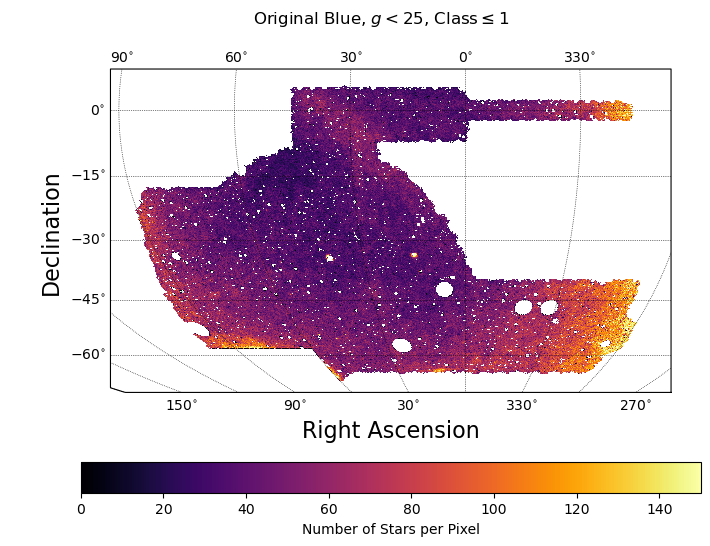

In [34]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspOrig, cmap = 'inferno')
plt.clim(0, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'Original Blue, $g<25$, Class$\leq$' + str(int(Class_Cutoff)))
plt.show()

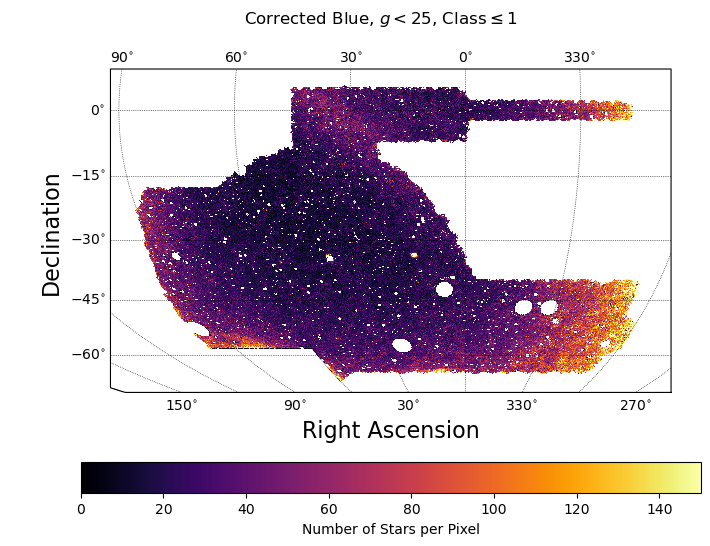

In [35]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspCorr, cmap = 'inferno')
plt.clim(0, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'Corrected Blue, $g<25$, Class$\leq$' + str(int(Class_Cutoff)))
plt.show()

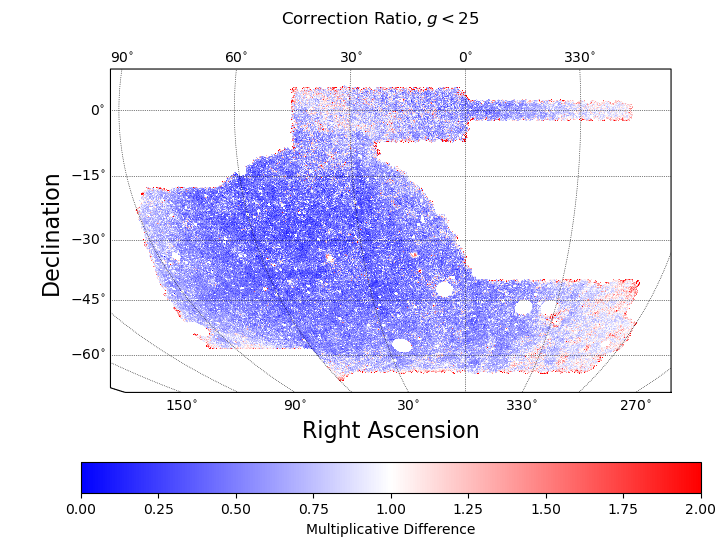

In [36]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspRatio, cmap = 'bwr')
plt.clim(0, 2)
plt.colorbar(location = 'bottom', label = 'Multiplicative Difference')
fig.suptitle(r'Correction Ratio, $g<25$')
plt.show()

In [37]:
# The default DES projection is a McBrydeSkymap.
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111)
# sp = skyproj.DESSkyproj(ax=ax)
# sp.draw_hspmap(hspProbs, cmap = 'viridis')
# plt.clim(0.85, 0.95)
# plt.colorbar(location = 'bottom', label = 'Detection Rate')
# fig.suptitle(r'Galaxy Correct Classification Probability, $24<g<25$')
# plt.show()

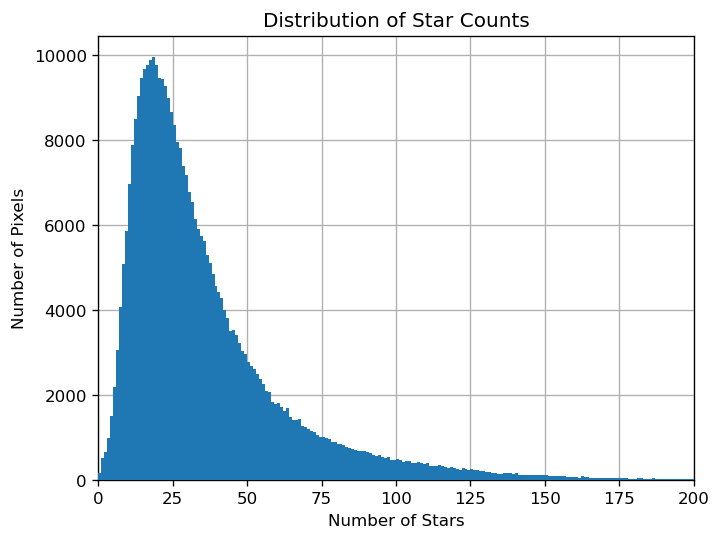

In [38]:
# By default it will clump everything beyond the last bin into it, so go one further.
plt.figure(dpi = 120)
weightCorr = plt.hist(fullCorrStar, bins = np.linspace(0, 201, 202), zorder = 3)
plt.ylabel('Number of Pixels')
plt.xlabel('Number of Stars')
plt.title('Distribution of Star Counts')
plt.grid(zorder = 0)
plt.xlim([0, 200])
plt.show()

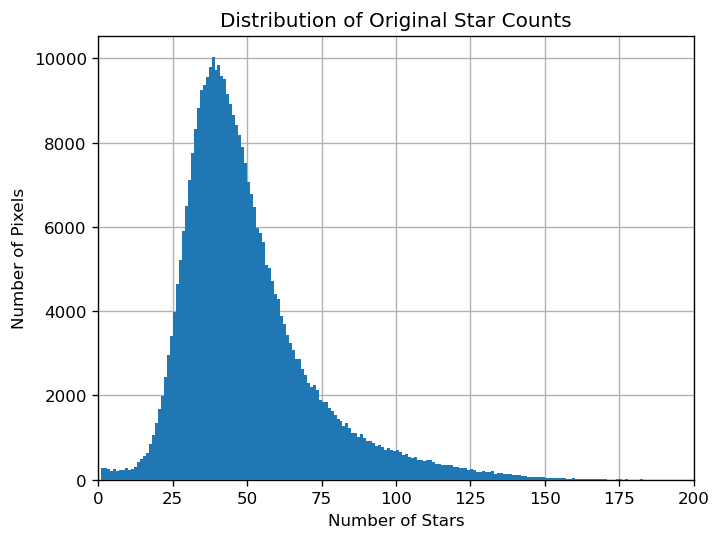

In [39]:
# By default it will clump everything beyond the last bin into it, so go one further.
plt.figure(dpi = 120)
weightOrig = plt.hist(fullOrigStar, bins = np.linspace(0, 201, 202), zorder = 3)
plt.ylabel('Number of Pixels')
plt.xlabel('Number of Stars')
plt.title('Distribution of Original Star Counts')
plt.grid(zorder = 0)
plt.xlim([0, 200])
plt.show()

In [40]:
len(np.where(fullCorrStar == 0)[0]) / len(np.where(fullCorrStar >= 0)[0])

7.069309138169648e-05

In [41]:
np.median(corrStar)

25.913994669547776

In [42]:
np.average(corrStar)

33.09226499856465

In [43]:
np.median(origStar)

43.0

In [44]:
np.average(origStar)

45.69577104062281

In [45]:
np.median(obsGala[4])

215.0

In [46]:
verificationDir = likeDir + 'Verification/'
my_table = Table()
my_table['CORR'] = weightCorr[0]
my_table['ORIG'] = weightOrig[0]
my_table.write(verificationDir + str(Class_Cutoff) + '_Class_Star_Count_Histograms.fits', overwrite = True)

In [47]:
# testPix = np.full(12*(512**2), False, dtype = bool)
# testPix[deepPix] = True
# testPix[np.where(fullCorrStar < 0)[0]] = False
# np.sum(fullCorrStar[testPix])

## Data for Validation

This will be storing data for a validation test.

In [48]:
cropValPix = np.full(12*(512**2), False, dtype = bool)
cropValPix[np.where(fullOrigStar > 0)[0]] = True
cropValPix = np.where(cropValPix)[0]

In [49]:
T_S = fullCorrStar[cropValPix]
# O_G = fullCorrGala[cropValPix]

In [50]:
# probCrop = np.zeros(12*(512**2))
# probCrop[validPix] = 1
# probCrop[cropValPix] = 2
# probCrop = probCrop[np.where(probCrop > 0)[0]]
# probCrop = np.where(probCrop == 2)[0]

In [51]:
# # Only one probability map will be stored for now, just to see how they look.
# P_OS_TS = starDetProb[4][probCrop].astype(float)
# P_CS_OS = starCorrProb[4][probCrop].astype(float)
# P_CG_OG = galaCorrProb[4][probCrop].astype(float)

In [52]:
verificationFile = likeDir + 'Verification/'+str(Class_Cutoff)+'_Class_Corrected_Star_Counts.fits' 

my_table = Table()
my_table['PIX'] = cropValPix
my_table['T_S'] = T_S
# my_table['O_G'] = O_G
# my_table['P_OS_TS'] = P_OS_TS
# my_table['P_CS_OS'] = P_CS_OS
# my_table['P_CG_OG'] = P_CG_OG
my_table.write(verificationFile, overwrite = True)